# Optimized+augmented PyTorch CNN

In this notebook, we train the winning CNN architecture from the Optuna run in notebook 04 on the CIFAR-10 dataset with image augmentation for improved generalization.

## Notebook set-up

### Imports

In [1]:
# Standard library imports
import pickle
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Package imports
from image_classification_tools.pytorch.data import (
    load_dataset, prepare_splits, create_dataloaders, generate_augmented_data
)
from image_classification_tools.pytorch.hyperparameter_optimization import create_cnn
from image_classification_tools.pytorch.plotting import (
    plot_learning_curves, plot_confusion_matrix,
    plot_class_probability_distributions,
    plot_evaluation_curves
)

from image_classification_tools.pytorch.training import train_model

### Configuration

In [11]:
# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Image data directory
data_dir = Path('../data/pytorch/cifar10')

# Data augmentation
augmented_data_path = Path('../data/pytorch/cifar10_augmented') # Path to save/load augmented data
augmented_data_path.mkdir(parents=True, exist_ok=True)

# Optuna study storage
storage_path = Path('../data/pytorch/cnn_optimization.db')
storage_url = f'sqlite:///{storage_path}'

# Suppress Optuna info messages
optuna.logging.set_verbosity(optuna.logging.WARNING)

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

num_classes = len(class_names)

Using device: cuda:1


### Hyperparameters

In [ ]:
# Split sizes
val_size = 10000

# Data augmentation
force_reaugment = False # Set to True to force regeneration of augmented data even if saved data exists
augmentations_per_image = 3

# Training
epochs = 30
print_every = 5

## 1. Load optimization results

In [4]:
# Get optimization results from disk
study = optuna.load_study(
    study_name='cnn_optimization',
    storage=storage_url
)

# Extract hyperparameters from winning trial
best_params = study.best_trial.params
batch_size = best_params['batch_size']

print('Loaded best hyperparameters from Optuna study:')

for key, value in best_params.items():
    print(f'  {key}: {value}')

print(f'\nBest validation accuracy from optimization: {study.best_trial.value:.2f}%')
print(f'Using batch size: {batch_size}')

Loaded best hyperparameters from Optuna study:
  batch_size: 128
  n_conv_blocks: 5
  initial_filters: 32
  n_fc_layers: 3
  conv_dropout_rate: 0.17380147046267944
  fc_dropout_rate: 0.4250817601248304
  learning_rate: 0.005391936260639258
  optimizer: SGD
  weight_decay: 5.397268412529651e-05
  sgd_momentum: 0.8283619030362693

Best validation accuracy from optimization: 87.22%
Using batch size: 128


## 1. Load and preprocess CIFAR-10 data

Load the images into PyTorch tensors and split them into training, validation and testing datasets as before, but this time generate an augmented dataset and store it on disk.

### 1.1. Define preprocessing transforms

In [5]:
# Define transform (RGB)
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

### 1.2. Load the training and testing datasets from disk

In [6]:
train_dataset = load_dataset(
    data_source=datasets.CIFAR10,
    transform=input_transform,
    root=data_dir
)

test_dataset = load_dataset(
    data_source=datasets.CIFAR10,
    transform=input_transform,
    root=data_dir,
    train=False
)

### 1.3. Training, validation and testing split

In [7]:
train_dataset, val_dataset, test_dataset = prepare_splits(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    val_size=val_size
)

### 1.4. Data augmentation

Generate augmented images and save to disk in ImageFolder format. The function processes images in chunks to avoid memory issues, saving each image (original + augmentations) as a PNG file organized by class.

In [8]:
# Define augmentation transforms (applied to already normalized tensors)
augmentation_transforms = nn.Sequential(
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=15)], p=0.1),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)], p=0.1),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
    transforms.RandomApply([transforms.Lambda(lambda x: -x)], p=0.1),  # Color inversion (negative)
    transforms.RandomApply([transforms.Lambda(lambda x: x[:, torch.randperm(3)])], p=0.3),  # Shuffle RGB channels
    transforms.RandomApply([transforms.Lambda(lambda x: x[:, 0].unsqueeze(1).repeat(1, 3, 1, 1))], p=0.1),  # Duplicate R channel
    transforms.RandomApply([transforms.Lambda(lambda x: x[:, 1].unsqueeze(1).repeat(1, 3, 1, 1))], p=0.1),  # Duplicate G channel
    transforms.RandomApply([transforms.Lambda(lambda x: x[:, 2].unsqueeze(1).repeat(1, 3, 1, 1))], p=0.1),  # Duplicate B channel
)

In [9]:
# Generate augmented dataset and save to disk
generate_augmented_data(
    train_dataset=train_dataset,
    augmentation_transforms=augmentation_transforms,
    augmentations_per_image=augmentations_per_image,
    save_dir=augmented_data_path,
    class_names=class_names,
    chunk_size=50000,
    force_reaugment=force_reaugment
)

Scanning dataset for classes...
Found 10 classes
Saving augmented images to ../data/pytorch/cifar10_augmented
Processing 40000 images in 1 chunk(s)
Generating 3 augmentations per image

Chunk 1/1 (images 0-39999)...
  Chunk 1 complete

Augmentation complete!
  Total images saved: 160000
  Original images: 40000
  Augmented images: 120000
  Augmentation factor: 4.0x
  Location: ../data/pytorch/cifar10_augmented


### 1.6. Load augmented dataset and create dataloaders

Load the augmented dataset from disk using the existing load_datasets function with ImageFolder.

In [12]:
# Load augmented training data using ImageFolder
augmented_train_dataset = load_dataset(
    data_source=augmented_data_path,
    transform=input_transform
)

# Create DataLoaders using the existing function
train_loader, val_loader, test_loader = create_dataloaders(
    augmented_train_dataset, val_dataset, test_dataset,
    batch_size=batch_size,
    preload_to_memory=True,
    device=device
)

print(f'Augmented training set: {len(augmented_train_dataset)} images')
print(f'Validation set: {len(val_dataset)} images')
print(f'Test set: {len(test_dataset)} images')

Augmented training set: 160000 images
Validation set: 10000 images
Test set: 10000 images


## 2. Build optimized CNN using best hyperparameters

Create a CNN using the best hyperparameters found during Optuna optimization, then train it with data augmentation.

### 2.2. Create model with best hyperparameters

In [13]:
# Create model with best hyperparameters from Optuna
model = create_cnn(
    n_conv_blocks=best_params['n_conv_blocks'],
    initial_filters=best_params['initial_filters'],
    n_fc_layers=best_params['n_fc_layers'],
    conv_dropout_rate=best_params['conv_dropout_rate'],
    fc_dropout_rate=best_params['fc_dropout_rate'],
    num_classes=num_classes,
    in_channels=3
).to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'\nTotal parameters: {trainable_params:,}')

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.17380147046267944, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.17380147046267944, inplace=False)
  (16): Conv2d(64

### 2.3. Define loss function and optimizer

In [14]:
criterion = nn.CrossEntropyLoss()

# Create optimizer with best hyperparameters
if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(
        model.parameters(), 
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )

elif best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(
        model.parameters(), 
        lr=best_params['learning_rate'],
        momentum=best_params.get('sgd_momentum', 0.9),
        weight_decay=best_params['weight_decay']
    )

else:  # RMSprop
    optimizer = optim.RMSprop(
        model.parameters(), 
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )

print(f"Optimizer: {best_params['optimizer']}")

Optimizer: SGD


### 2.4. Train model

In [15]:
%%time

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    print_every=print_every
)

print()

Epoch   1/30 - loss: 2.0027 - acc: 22.79% - val_loss: 2.4112 - val_acc: 20.63%
Epoch   5/30 - loss: 1.2247 - acc: 59.16% - val_loss: 1.2680 - val_acc: 55.88%
Epoch  10/30 - loss: 0.9536 - acc: 69.03% - val_loss: 0.8795 - val_acc: 70.02%
Epoch  15/30 - loss: 0.8075 - acc: 73.83% - val_loss: 0.8382 - val_acc: 72.21%
Epoch  20/30 - loss: 0.7003 - acc: 77.43% - val_loss: 0.7606 - val_acc: 75.65%
Epoch  25/30 - loss: 0.6183 - acc: 80.11% - val_loss: 0.7642 - val_acc: 76.16%
Epoch  30/30 - loss: 0.5490 - acc: 82.41% - val_loss: 0.8114 - val_acc: 75.90%

CPU times: user 25min 39s, sys: 19.6 s, total: 25min 58s
Wall time: 25min 31s


### 2.5. Learning curves

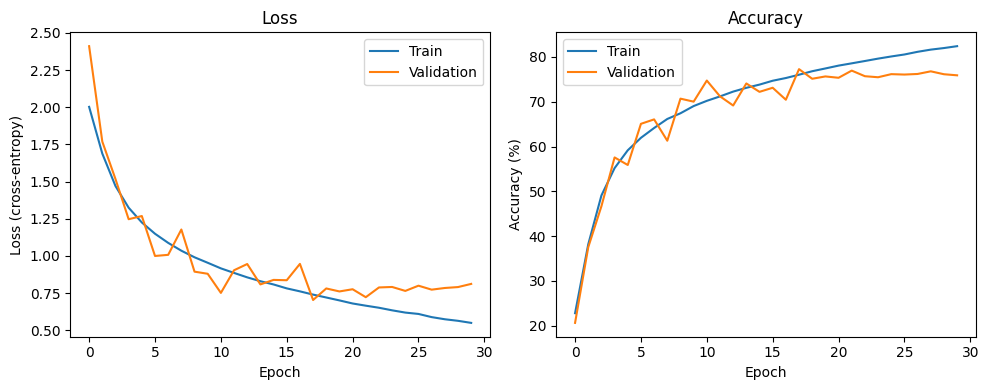

In [16]:
fig, axes = plot_learning_curves(history)
plt.show()

## 3. Evaluate model on test set

### 3.1. Calculate test accuracy

In [17]:
# Custom evaluation with per-batch GPU transfer
model.eval()
predictions = []
true_labels = []
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 76.40%


### 3.2. Per-class accuracy

In [18]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in class_names}
class_total = {name: 0 for name in class_names}

for pred, true in zip(predictions, true_labels):

    class_name = class_names[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in class_names:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 81.10%
automobile  : 84.70%
bird        : 66.90%
cat         : 67.00%
deer        : 78.30%
dog         : 54.70%
frog        : 81.60%
horse       : 72.50%
ship        : 96.70%
truck       : 80.50%


### 3.3. Confusion matrix

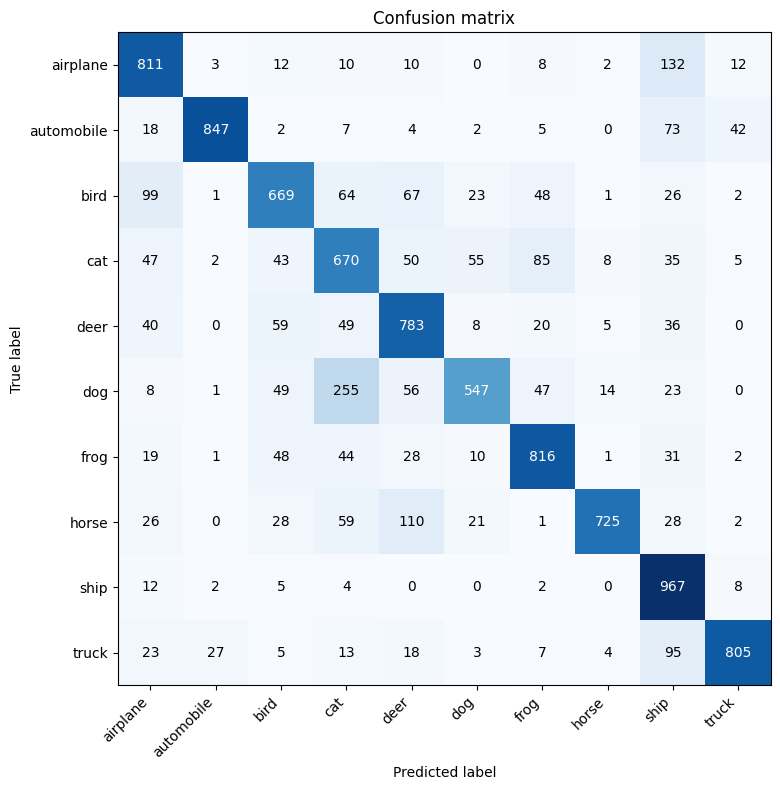

In [19]:
fig, ax = plot_confusion_matrix(true_labels, predictions, class_names)
plt.show()

### 3.4. Predicted class probability distributions

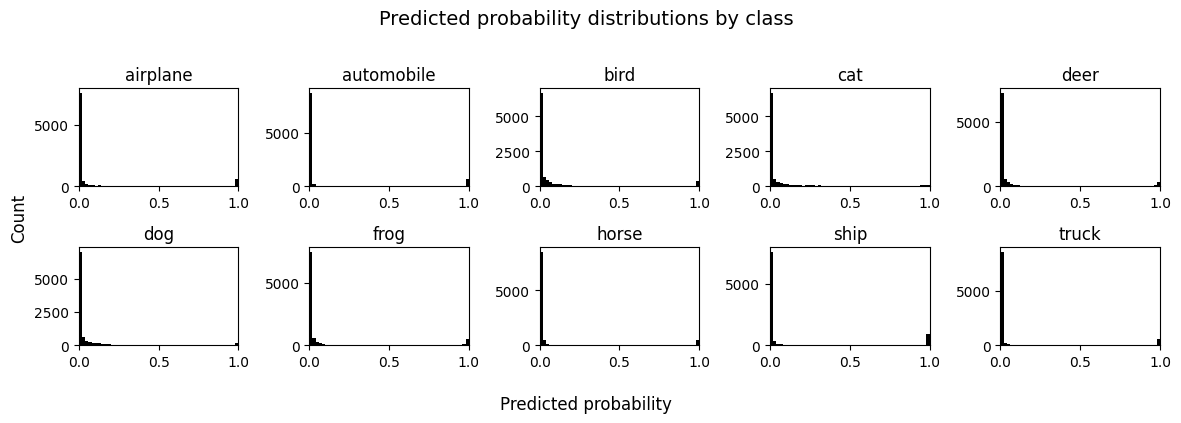

In [20]:
# Get predicted probabilities for all test samples
model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device, non_blocking=True)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Plot probability distributions
fig, axes = plot_class_probability_distributions(all_probs, class_names)
plt.show()

### 3.5. Evaluation curves

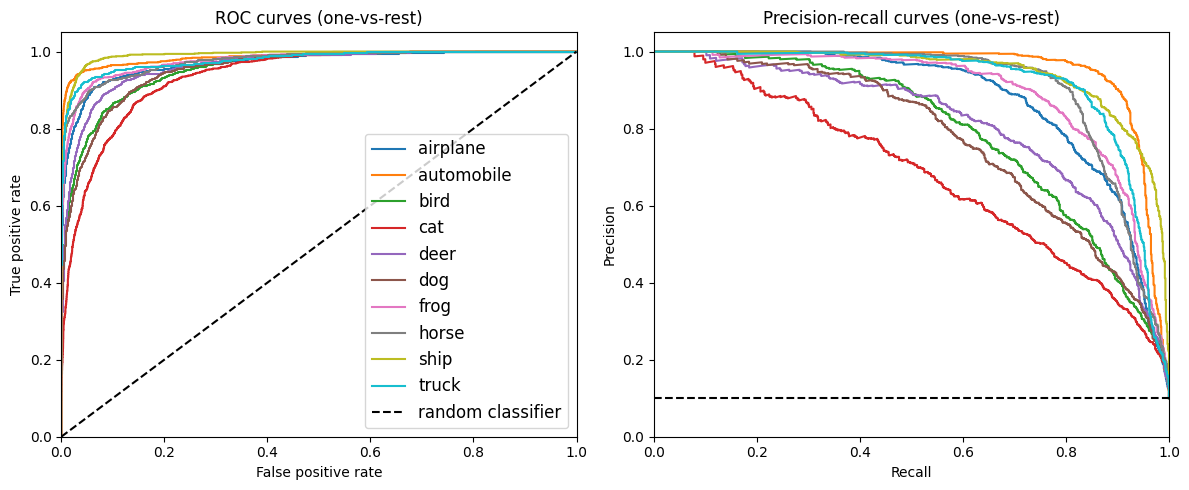

In [21]:
fig, (ax1, ax2) = plot_evaluation_curves(true_labels, all_probs, class_names)
plt.show()

## 4. Save model

In [22]:
# Create models directory if it doesn't exist
models_dir = Path('../models/pytorch')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model state dict
model_path = models_dir / 'augmented_cnn.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_accuracy': test_accuracy,
    'history': history
}, model_path)

print(f'Model saved to: {model_path}')
print(f'Test accuracy: {test_accuracy:.2f}%')

Model saved to: ../models/pytorch/augmented_cnn.pth
Test accuracy: 76.40%


## 5. Save test results for comparison

In [23]:
# Create results directory
models_dir = Path('../data/pytorch/performance_results')
models_dir.mkdir(parents=True, exist_ok=True)
results_path = models_dir / 'augmented_cnn_results.pkl'

# Count model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Create results dictionary
results_dict = {
    'true_labels': true_labels,
    'predictions': predictions,
    'all_probs': all_probs,
    'test_accuracy': test_accuracy,
    'total_params': total_params,
    'trainable_params': trainable_params
}

# Save results
with open(results_path, 'wb') as f:
    pickle.dump(results_dict, f)

print(f'Test results saved to: {results_path}')
print(f'  - Test accuracy: {test_accuracy:.2f}%')
print(f'  - Total parameters: {total_params:,}')
print(f'  - Trainable parameters: {trainable_params:,}')

Test results saved to: ../data/pytorch/performance_results/augmented_cnn_results.pkl
  - Test accuracy: 76.40%
  - Total parameters: 4,889,322
  - Trainable parameters: 4,889,322
